In [ ]:
# This is a new Julia notebook :)
# This program is for getting an understanding of how to use nested sampling

In [ ]:
#=
TO DO LIST (calculating Kinetic Energy):
- make function for computing particle velocities (via verlet method)
        - is it possible to find velocity separate from finding new position...?
        - consider using velocity verlet instead (wikipedia page) of position verlet
- give velocities at end of MD simulation period
- use velocities to compute Kinetic Energy



TO DO LIST (nested sampling):
X Create initial random samples for nested sampling, define qualities
X compare samples' energies
X delete highest total energy sample and clone a different sample 
X walk the cloned sample, decorrelate by changing speeds
X walk all samples and then repeat energy check, clone, etc. ...
X do this for some iterations, then compare original max sample energy to the final max sample energy

TO DO LIST (heat capacity):
- Record highest potential energies
- Make sure each potential is lower than the last
- Calculate partition function
- Cv = -(δ/δT δlnZ/δβ)v
    - β = 1/(kT)
    - k = kB = Bolzmann constant
    - En = energy recorded at level n
    UNITLESS
    - K = num_samples
    - wn = α^n - α^(n+1)
    - α = (K-1)/K
    - N = number of particles in a sample
    - Zest  = Σn [α^n - α^(n+1)] * [exp(-β*E(xj))]
        (this only works for our specific choice of α)
- GOAL: T in kelvins, Cv in eV per kelvin
* Try setting initital velocities to 0, or have them far apart
X Make sure potential energy drops to zero at σ

TO DO LIST (phase diagram):
- Figure out how to choose set of pressures
- Learn how to use NS results to calculate heat capacity
- Learn how to find maxima on p-T curves
- Graph results
=#

"""Go through function definitions and remove all global variables"""

In [ ]:
#=
Nested Sampling Algorithm STEPS:
1. Generate K random samples (walkers) uniformly in the total phase space volume (Potential Energy Surface)
2. Calculate energies of each sample
3. Delete highest energy sample with energy E1
4. Generate new sample with E<E1
    - Clone a random sample and perform a random walk until it is independent from the parent configuration.
        - Markov Chain Monte Carlo
        - Total Enthalpy Hamiltonian Monte Carlo
        - Galilean Monte Carlo
5. Repeat many times...
6. Reach bottom, calculate thermodynamic quantities.

• Do samples of 64 LJ atoms at constant pressure

p-T Phase Diagram STEPS:
1. Choose a set of pressures and do NS calculations for each pressure
2. Calculate cp(T) for every sampled pressure.
3. Locate maxima on cp(T) curves.
=#

In [1]:
# Run this cell ONCE; it takes time and doesn't need to be run more than once
# Rerun if you shutdown the kernel
using Pkg
Pkg.add("Plots")
Pkg.add("GR")
using Plots

# Default
gr(title = "no title", legend = :none, background_color = :black)

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


Plots.GRBackend()

In [1]:
"""COSTANTS"""

# These values are in reduced units, defined by the properties of the element argon
ϵ = 1             # ENERGY, Depth of potential well, ϵ = kB * 120 K for Argon
m = 1             # MASS of an argon atom, "Reduced mass", determines other properties like ϵ, σ
σ = 1             # DISTANCE unit, 3.4Å for argon


N  = 4                    # number of particles on one side
K  = N^2                  # total number of particles
num_particles = K
ς = 3 * σ                 # Max distance where interference is possible
sqς = ς^2                 # Square of max distance where interference is possible, useful for our functions
dt = 0.0001 * sqrt(m*σ^2/ϵ) # time step size
ds = 1.5 * σ              # grid spacing
L  = 1.5 * N * ds         # system size
dr = 0.1 * σ              # max deviation from grid position
v0 = 0.5 * sqrt(ϵ/m)      # max initial velocity magnitude
vxavg = 0 * v0            # system average velocity in x direction
vyavg = 0 * v0            # system average velocity in y direction

F_cutoff = (-24*ς^(-7) + 48*ς^(-13)) # Force at cutoff distance. Subtract from force so F at ς is zero.
PE_cutoff = 4*ϵ*((σ/ς)^12 - (σ/ς)^6) # Potential at cutoff distance. Subtract from pot. so PE at ς is zero.


T = 2000 # number of timesteps to take
s = 10 # Desired number of iterations between data recorded for plots

if T%s != 0
    println("Number of timesteps (T) must be evenly divisible by (s)!\n")
    println("Change (s) or (T) so that [T%s == 0]")
end


#kB = 1.380649*10^(-23)  #Boltzmann constant in units of J/K
kB = 8.617333*10^(-5)  #Boltzmann constant in units of eV/K

# UNIT CONVERSIONS
# These will be used to convert the calculated energies into useful units.
# The following values are true for Argon.
ϵ_val = kB * 120 / ϵ              # energy
m_val = 6.6335209*10^(-26) / m    # kilograms
σ_val = 3.4*10^(-10) / σ          # meters
t_val = sqrt(m_val*σ_val^2/ϵ_val) # seconds, should be 1.8x10^-12...
v_val = sqrt(ϵ_val/m_val)         # m/s

# This factor is used in the get_energy function to brute-force KE_total+PE_total into being constant...
PE_factor = 0.5;

In [2]:
#=
Calculating force of particle j on particle i
=#


function comp_force(sqς, xi, xj, yi, yj, Fx, Fy, i, r = (xi - xj)^2 + (yi - yj)^2)
    
    # Check if i and j are too far apart to matter
    if r < sqς
        r = sqrt(r)
        
        # Calculate magnitude of force from particle j
        F = (-24*r^(-7) + 48*r^(-13)) - F_cutoff
        
        #F_cutoff is the tiny bit of force at r = rsqς
        
        # Calculate x and y components of force from j, then add to net force on i
        Fx[i] += (xi - xj) / r * F  # cos(theta) * F
        Fy[i] += (yi - yj) / r * F  # sin(theta) * F 
    end
    
end

comp_force (generic function with 2 methods)

In [3]:
#=
Using Verlet method to get new position
=#

function newposition(K,L,z,zprev,Fz,dt,vz,n,T)
    
    for i in 1:K
        # z[n+1]
        znew = 2z[i] - zprev[i] + Fz[i]*dt^2
        # vz[n]
        vz[i] = (znew - zprev[i]) / (2*dt)
        
        ############# SPECIAL NOTE #############
        #=
        By the end of this function, vz[i] matches the new zprev[i]/old z[i]
        rather than the new z[i]. That might be important when it comes to
        correctly calculating a sample's "current" potential and kinetic energy.
        =#
        
        #=
        Running velocity calculation here is not ideal 
        since this logic check gets run at every loop of particle path calculation.
        However, the velocity calculation needs the old z and zprev, 
        not the new set given at the end of this function, 
        so it needs to be calculated inside this function.
        =#
        
        
        # If new position falls out of bounds, pull it in on opposite side
        # Also do this for previous position so it doesn't muck up later calculations 
        if znew >= L
            zprev[i] = z[i] - 2L
            z[i] = znew - 2L
        elseif znew < -L
            zprev[i] = z[i] + 2L
            z[i] = znew + 2L
        else
            zprev[i] = z[i]
            z[i] = znew
        end
        
        
    end
        
end

newposition (generic function with 1 method)

In [4]:
#=
Takes each particle's current coordinates and saves them to a small array, 
then saves that small array to a bigger array. It will be used to animate our particles.
Each small array has the information to plot one frame of an animation.
=#

function recordpositions(K,x,y,x_for_gif,y_for_gif)
    
    # Initialize for adding array to plot in gif
    temp_x = []
    temp_y = []   
    
    for i in 1:K
        # Create small list of particle positions for one frame
        push!(temp_x, x[i])
        push!(temp_y, y[i]) 
    end

    # Push small lists to large arrays
    push!(x_for_gif, temp_x)
    push!(y_for_gif, temp_y)
    
end

recordpositions (generic function with 1 method)

In [5]:
#=
Takes each particle's current velocities and saves them to a small array, 
then saves that small array to a bigger array. It's not used for the animation.
Each small array has information about one frame of the animation.
=#

function recordvelocities(K,vx,vy,vx_tmp,vy_tmp)
    
    # Initialize small arrays
    temp_vx = []
    temp_vy = []   
    
    for i in 1:K
        # Create small list of particle velocities of one frame
        push!(temp_vx, vx[i])
        push!(temp_vy, vy[i]) 
    end

    # Push small lists to large arrays
    push!(vx_tmp, temp_vx)
    push!(vy_tmp, temp_vy)
    
end

recordvelocities (generic function with 1 method)

In [6]:
#=
This function creates the nearest periodic version from the getgo by examining which boundaries each
particle is nearest to.
=#

function oneimage(L,ς,sqς,xi,xj,yi,yj,Fx,Fy,i)
    
    #= 
    Find minimum between distance to upper bound, lower bound, and cutoff distance. 
    Use result for creating  nearest periodic version of particle j. Repeat comparison with other coordinates.
    =#
    
    #= 
    In either dimension, there are 3 areas: near lower periodic boundary, near upper one, or near neither of them.
    
    If i coord is much higher than j coord, j will be transformed to be 2L higher.
    If i coord is much lower than j coord, j will be transformed to be 2L lower.
    If i coord and j coord are in about the same area, j coord will not be transformed.
    =#
    
    # Check if xi is within cutoff of boundary
    if (L - abs(xi)) >= ς
        nbxi = 0
    else
        nbxi = sign(xi)
    end
    
    
    # Check if xj is within cutoff of boundary
    if (L - abs(xj)) >= ς
        nbxj = 0
    else
        nbxj = sign(xj)
    end
    

    # Check if yi is within cutoff of boundary
    if (L - abs(yi)) >= ς
        nbyi = 0
    else
        nbyi = sign(yi)
    end
    
    
    # Find nearest boundary to yj
    # Check if yj is within cutoff of boundary
    if (L - abs(yj)) >= ς
        nbyj = 0
    else
        nbyj = sign(yj)
    end

    
    npx = xj + (abs(nbxi*nbxj))*sign(nbxi-nbxj)*2*L
    npy = yj + (abs(nbyi*nbyj))*sign(nbyi-nbyj)*2*L
    
    
    comp_force(sqς,xi,npx,yi,npy,Fx,Fy,i)
    
end

oneimage (generic function with 1 method)

In [7]:
#=
Takes the computation function you wish to use as a parameter, computes particle paths
=#

function comp_path(K,L,ς,sqς,x,y,Fx,Fy,chosen_way::Function)
    
    # Calculating net force on each particle one at a time
    
    
    for i in 1:K
        # Initialize forces as zero, we will add on forces from each other particle
        Fx[i] = 0
        Fy[i] = 0
        
        #= 
        If particle i is far from any system boundaries, do force calculations only inside main system.
        =#
        if L-abs(x[i])>=ς && L-abs(y[i])>=ς
                
            for j in 1:K

                # Check if i and j are same particle; particle i can't act on itself
                if i == j
                    continue
        
                else
                    comp_force(sqς,x[i],x[j],y[i],y[j],Fx,Fy,i)
                    
                end
                
            end
         
            
        #= 
        Since particle i is near a boundary, check if particle j 
        is also near any system boundaries. If so do force calculations
        with periodic versions of j. If not, use versions of j within system.
        =#
        else
            
            # Calculate forces from each other particle
            for j in 1:K

                # Check if i and j are same particle; particle i can't act on itself
                if i == j
                    continue
                    
                # If particle j is far from any system boundaries, do force calculations only inside main system.    
                elseif L-abs(x[j])>=ς && L-abs(y[j])>=ς
                    comp_force(sqς,x[i],x[j],y[i],y[j],Fx,Fy,i)
    
                else
                    chosen_way(L,ς,sqς,x[i],x[j],y[i],y[j],Fx,Fy,i) 
                    
                end # if i == j ...
                
            end # for j in 1:K
            
            
        end # if abs(L-x[i])>=3 && abs(L-y[i])>=3 ...
        
    end # for i in 1:K
    
end

comp_path (generic function with 1 method)

In [8]:
function comp_potential(sqς, xi, xj, yi, yj, LJ_PEs, i, r = (xi - xj)^2 + (yi - yj)^2)
    
    # Check if i and j are too far apart to matter
    if r < sqς
        r = sqrt(r)
        # Add UNITS
        # Calculate LJ potential from particle j
        LJ_PEs[i] += (4*ϵ*((σ/r)^12 - (σ/r)^6) - PE_cutoff)
                    #PE_cutoff is the bit of potential at r = sqς
        
    end
    
end

comp_potential (generic function with 2 methods)

In [9]:
#=
This function creates the nearest periodic version from the getgo by 
examining which boundaries each particle is nearest to.
=#

function periodic_potential(L,ς,sqς,xi,xj,yi,yj,LJ_PEs,i)
    
    #= 
    Find minimum between distance to upper bound, lower bound, and cutoff distance. 
    Use result for creating  nearest periodic version of particle j. Repeat comparison with other coordinates.
    =#
    
    #= 
    In either dimension, there are 3 areas: near lower periodic boundary, near upper one, or near neither of them.
    
    If i coord is much higher than j coord, j will be transformed to be 2L higher.
    If i coord is much lower than j coord, j will be transformed to be 2L lower.
    If i coord and j coord are in about the same area, j coord will not be transformed.
    =#
    
    # Check if xi is within cutoff of boundary
    if (L - abs(xi)) >= ς
        nbxi = 0
    else
        nbxi = sign(xi)
    end
    
    
    # Check if xj is within cutoff of boundary
    if (L - abs(xj)) >= ς
        nbxj = 0
    else
        nbxj = sign(xj)
    end
    

    # Check if yi is within cutoff of boundary
    if (L - abs(yi)) >= ς
        nbyi = 0
    else
        nbyi = sign(yi)
    end
    
    
    # Find nearest boundary to yj
    # Check if yj is within cutoff of boundary
    if (L - abs(yj)) >= ς
        nbyj = 0
    else
        nbyj = sign(yj)
    end

    
    npx = xj + (abs(nbxi*nbxj))*sign(nbxi-nbxj)*2*L
    npy = yj + (abs(nbyi*nbyj))*sign(nbyi-nbyj)*2*L
    
    
    comp_potential(sqς,xi,npx,yi,npy,LJ_PEs,i)
    
end

periodic_potential (generic function with 1 method)

In [10]:
#=
Computes energy of a sample
=#

function get_energy(K,L,m,ς,sqς,x,y,vx,vy)
    
    # Calculating potential energy and kinetic energy of each particle
    
    # Initialize potential and kinetic energy vectors for summing later
    LJ_PEs = zeros(K)
    LJ_KEs = zeros(K)
    
    for i in 1:K
        
        #= 
        If particle i is far from any system boundaries, do potential calculations only inside main system.
        =#
        if L-abs(x[i])>=ς && L-abs(y[i])>=ς
                
            for j in 1:K

                # Check if i and j are same particle; particle i can't act on itself
                if i == j
                    continue
        
                   
                else
                    comp_potential(sqς,x[i],x[j],y[i],y[j],LJ_PEs,i)
                    
                end
                
            end
         
            
        #= 
        Since particle i is near a boundary, check if particle j 
        is also near any system boundaries. If so, do potential calculations
        with periodic versions of j. If not, use versions of j within system.
        =#
        else
            
            # Calculate potentials from each other particle
            for j in 1:K

                # Check if i and j are same particle; particle i can't act on itself
                if i == j
                    continue
                    
                # If j is far from any system boundaries, do potential calculations only inside main system.    
                elseif L-abs(x[j])>=ς && L-abs(y[j])>=ς
                    comp_potential(sqς,x[i],x[j],y[i],y[j],LJ_PEs,i)
    
                else
                    periodic_potential(L,ς,sqς,x[i],x[j],y[i],y[j],LJ_PEs,i) 
                    
                end # if i == j ...
                
            end # for j in 1:K
            
            
        end # if abs(L-x[i])>=3 && abs(L-y[i])>=3 ...
        
        """Check that the v's are current with position when this function is used"""
        LJ_KEs[i] = m/2*(vx[i]^2+vy[i]^2)
                
    end # for i in 1:K
    
    # We use both kinetic energy and potential energy because that's what's needed to
    # force the system to cool off
    # KE_total should be adding to PE_total to the same E total value always...
    
    PE_total = sum(LJ_PEs) * PE_factor
    KE_total = sum(LJ_KEs)    
    # PE_factor is necessary to get it so that E_total is constant...
    
    
    return PE_total, KE_total
    
end # Function

get_energy (generic function with 1 method)

In [11]:
### INITIAL SAMPLES

#= 
Work could be done to make samples have differing average velocities
    or other things that could help differentiate them.
=#

function make_sample(index)
    #= 
    Each sample consists of an array of the current x, y, vx, vy, 
        xprev, and yprev values.
    Each one also has an index, given while the sample is created.
    The index may or may not be useful later, but it's easy to add.
    =#
    
    # Initialize vectors
    init_x = []
    init_y = []
    init_vx = []
    init_vy = []
    init_xprev = []
    init_yprev = []

    k = 1 #iterator for creating particle grid


    # Create grid of NxN particles
    for i in 1:N
        for j in 1:N
            # Create coordinates for particle ij, move so grid center is at origin, 
            # spaced as far as 2*L/N apart, or as low as 0.5*σ apart, then displace randomly
            push!(init_x,((i-1) - (N-1)/2)*L/N + (rand() - 0.5)*dr)
            push!(init_y,((j-1) - (N-1)/2)*L/N + (rand() - 0.5)*dr)

            # Randomize initial velocity for calculating ghost previous position
            push!(init_vx,(rand() - 0.5)v0 + vxavg)
            push!(init_vy,(rand() - 0.5)v0 + vyavg)

            # Use initial velocity for initializing ghost previous position
            push!(init_xprev,init_x[k] - init_vx[k]*dt)
            push!(init_yprev,init_y[k] - init_vy[k]*dt)

            k += 1
        end
    end

    # This is the sample that will be returned.
    init_vals = [init_x, init_y, init_vx, init_vy, init_xprev, init_yprev, index]
    
    
    return init_vals
    
end

make_sample (generic function with 1 method)

In [12]:
### Calculate particle paths using each method and record points for plotting

function walk_record(sample,x_for_anim_i,y_for_anim_i)


    x = deepcopy(sample[1])
    y = deepcopy(sample[2])
    vx = deepcopy(sample[3])
    vy = deepcopy(sample[4])
    xprev = deepcopy(sample[5])
    yprev = deepcopy(sample[6])
    
    
    x_anim_tmp = []
    y_anim_tmp = []
    
    
    # Initialize force vectors and arrays for plotting
    Fx = zeros(K)
    Fy = zeros(K)

    
    for n in 1:T

        # Calculating net force on each particle one at a time
        comp_path(K,L,ς,sqς,x,y,Fx,Fy,oneimage)

        # Updating coordinates and velocities Verlet method
        newposition(K,L,x,xprev,Fx,dt,vx,n,T)
        newposition(K,L,y,yprev,Fy,dt,vy,n,T)

        
        # Record the points every few time steps
        if n%s == 0
            recordpositions(K,x,y,x_anim_tmp,y_anim_tmp)
            
            # Final timestep, record the velocities and new initial values
            if n == T
            #recordvelocities(K,vx,vy,vx_tmp,vy_tmp)
                
            sample[1] = deepcopy(x)
            sample[2] = deepcopy(y)
            sample[3] = deepcopy(vx)
            sample[4] = deepcopy(vy)
            sample[5] = deepcopy(xprev)
            sample[6] = deepcopy(yprev)    
                
            end
            
        end

        
    end

    # Use velocities/positions to calculate kinetic/potential 
    # energies and find total energy
    # Ideally only potential energy is needed for heat capacity calculation.
    # However, that doesn't work when we're using MD, so we need both.
    
    PE_total,KE_total = get_energy(K,L,m,ς,sqς,xprev,yprev,vx,vy)
    
    ############# SPECIAL NOTE #############
        #=
        By the end of newposition, vz[i] matches the new zprev[i]/old z[i]
        rather than the new z[i]. So, to correctly calculating a sample's "current" 
        potential and kinetic energy, we have to use zprev and vz, not z.
        We'll be looking at its energy a frame before its current position.
        =#
    
    
    print("Total energy: ",PE_total+KE_total,"\n")   
      
    
    # Push each recorded value into the array for holding coordinates
    for i in 1:length(x_anim_tmp)
        push!(x_for_anim_i, deepcopy(x_anim_tmp[i]))
        push!(y_for_anim_i, deepcopy(y_anim_tmp[i]))
    end
    
    
    println("Sample ", sample[7], " has finished walking.\n\n")
    
    
    #return x_for_anim, y_for_anim
    
end

walk_record (generic function with 1 method)

In [13]:
# Finding and replacing the sample with the maximum energy
#"""Sort samples by their TOTAL energies!"""
#"""Decorrelate so that the new kinetic energy is lower than originally"""
function replace_max_sample(K,L,m,ς,sqς,samples_list,sample_energies)
    
    # Initialize array of energy totals
    E_tot_list = []
    # only potential energy is needed
    #PE_tot_list = []
      
    
    for i in 1:num_samples
        # Add each sample's total energy to the list
        vx = deepcopy(samples_list[i][3])
        vy = deepcopy(samples_list[i][4])
        xprev = deepcopy(samples_list[i][5])
        yprev = deepcopy(samples_list[i][6])
        PE_total,KE_total = get_energy(K,L,m,ς,sqς,xprev,yprev,vx,vy)
        push!(E_tot_list, PE_total+KE_total)
        #push!(PE_tot_list, PE_total)
    end

    max_E, max_index = findmax(E_tot_list)
    print("Sample ", max_index, " has the maximum energy, with E_tot = ", max_E,"\n")
    
    # Record max energy for making heat capacity plot
    push!(sample_energies, deepcopy(max_E))
    
    # Pick a random index to use to create a new, lower energy sample
    replacement_index = rand(1:num_samples)
    # If the index to deepcopy matches the current one, pick a different one
    while replacement_index == max_index
        replacement_index = rand(1:num_samples)
    end
    
    # Copy the information from the random index over the max sample
    samples_list[max_index][1] = deepcopy(samples_list[replacement_index][1]) #x
    samples_list[max_index][2] = deepcopy(samples_list[replacement_index][2]) #y
    samples_list[max_index][3] = deepcopy(samples_list[replacement_index][3]) #vx
    samples_list[max_index][4] = deepcopy(samples_list[replacement_index][4]) #vy
    samples_list[max_index][5] = deepcopy(samples_list[replacement_index][5]) #xprev
    samples_list[max_index][6] = deepcopy(samples_list[replacement_index][6]) #yprev
    
    
    vx = deepcopy(samples_list[max_index][3])
    vy = deepcopy(samples_list[max_index][4])
    xprev = deepcopy(samples_list[max_index][5])
    yprev = deepcopy(samples_list[max_index][6])
    PE_total,KE_total = get_energy(K,L,m,ς,sqς,xprev,yprev,vx,vy)
    
    
    print("Sample ",replacement_index," has replaced sample ",max_index,".\n")
    print("Sample ",max_index," now has a PE of ",PE_total,",\n")
    print("             a KE of ",KE_total,",\n")
    print("         and a total energy of ",PE_total+KE_total,".\n\n")
    
    
    # Use max_index to walk the replaced sample.
    return max_index
end

replace_max_sample (generic function with 1 method)

In [14]:
### This function walks a sample and slightly reduces its kinetic energy

"""Decorrelate so that the new kinetic energy is lower than originally
since the total energy shouldn't change by MD"""

"""Try decreasing the kinetic energy but then checking that the total
energy has decreased, rather than that the kinetic energy decreased."""

function decorrelate(sample)


    OG_sample = deepcopy(sample)
    
    x = deepcopy(sample[1])
    y = deepcopy(sample[2])
    vx = deepcopy(sample[3])
    vy = deepcopy(sample[4])
    xprev = deepcopy(sample[5])
    yprev = deepcopy(sample[6])
    
    PE_total,KE_total = get_energy(K,L,m,ς,sqς,xprev,yprev,vx,vy)
    
    E_total = PE_total+KE_total
    new_E_total = E_total
    
    J = 0  # Variable to iterate, make sure loop doesn't get out of hand
    
    # Decrease magnitude of velocities slightly and randomly
    # at least 95% and not more than 100% of original velocity
    low_end = 0.95
    high_end = 1.00 - low_end
    
    
    while new_E_total >= E_total
        
        J += 1
        #if J > 20
        #    print("Failed to decrease total energy within 20 iterations.\n")
        if J > 50
            print("Failed to decrease total energy within 50 iterations.\n")
            break
        end
        
        
        # Scale down velocities a little bit, change "prev" positions so algorithm works properly
        x = deepcopy(sample[1])
        y = deepcopy(sample[2])
        vx = (low_end+rand()*high_end) * deepcopy(sample[3])
        vy = (low_end+rand()*high_end) * deepcopy(sample[4])
        xprev = [];
        yprev = [];
        #"""I ripped this from the make_sample function, so it should work the same way..."""
        k = 1
        for i in 1:N
            for j in 1:N
                # Use initial velocity for reinitializing a ghost "previous position"
                push!(xprev,x[k] - vx[k]*dt)
                push!(yprev,y[k] - vy[k]*dt)
                k += 1
            end
        end
        
        # Initialize force vectors and arrays for plotting
        Fx = zeros(K)
        Fy = zeros(K)


        for n in 1:T

            # Calculating net force on each particle one at a time
            comp_path(K,L,ς,sqς,x,y,Fx,Fy,oneimage)

            # Updating coordinates and velocities Verlet method
            newposition(K,L,x,xprev,Fx,dt,vx,n,T)
            newposition(K,L,y,yprev,Fy,dt,vy,n,T)

            # Final timestep: check that total energy is less than intially; set new initial values if so
            if n == T
                
                new_PE_total,new_KE_total = get_energy(K,L,m,ς,sqς,xprev,yprev,vx,vy)
                new_E_total = new_PE_total+new_KE_total
                
                if new_E_total < E_total
                    # New energy total is less than originally, so update sample
                    sample[1] = deepcopy(x)
                    sample[2] = deepcopy(y)
                    sample[3] = deepcopy(vx)
                    sample[4] = deepcopy(vy)
                    sample[5] = deepcopy(xprev)
                    sample[6] = deepcopy(yprev)
                    print(new_E_total," is LESS than the original ",E_total,".\n")
                    break
                else
                    # Failed to decrease total energy, so reset to original values and try again
                    print(new_E_total," is MORE than the original ",E_total,".\n")
                end

            end

        end

    end   #While
    
    
    # Use velocities/positions to calculate kinetic/potential energies and find total energy
    new_PE_total, new_KE_total = get_energy(K,L,m,ς,sqς,xprev,yprev,vx,vy)
    E_total = PE_total + KE_total
    new_E_total = new_PE_total + new_KE_total
    
    print("Total potential energy changed from ",PE_total," to ",new_PE_total,".\n")
    print("Total kinetic energy changed from ",KE_total," to ",new_KE_total,".\n")
    print("Total energy changed from ",E_total," to ",new_E_total,".\n")    
    
    println("Sample ", sample[7], " has finished decorrelating.\n\n\n")
    
end

decorrelate (generic function with 1 method)

In [15]:
### Calculate particle paths using each method and record points for plotting
function walk_energies(sample,PE_list,KE_list,TE_list,timesteps)


    x = deepcopy(sample[1])
    y = deepcopy(sample[2])
    vx = deepcopy(sample[3])
    vy = deepcopy(sample[4])
    xprev = deepcopy(sample[5])
    yprev = deepcopy(sample[6])

    
    # Initialize force vectors and arrays for plotting
    Fx = zeros(K)
    Fy = zeros(K)

    
    for n in 1:T

        # Calculating net force on each particle one at a time
        comp_path(K,L,ς,sqς,x,y,Fx,Fy,oneimage)

        # Updating coordinates and velocities Verlet method
        newposition(K,L,x,xprev,Fx,dt,vx,n,T)
        newposition(K,L,y,yprev,Fy,dt,vy,n,T)

        
        # Record the points every few time steps
        if n%s == 0
            # Use velocities/positions to calculate kinetic/potential energies 
            # and find total energy
            PE_total,KE_total = get_energy(K,L,m,ς,sqς,xprev,yprev,vx,vy)
            
            push!(PE_list, PE_total)
            push!(KE_list, KE_total)
            push!(TE_list, PE_total+KE_total)
            push!(timesteps, n)
            
            # Final timestep, record the velocities and new initial values
            if n == T
            #recordvelocities(K,vx,vy,vx_tmp,vy_tmp)
                
            sample[1] = deepcopy(x)
            sample[2] = deepcopy(y)
            sample[3] = deepcopy(vx)
            sample[4] = deepcopy(vy)
            sample[5] = deepcopy(xprev)
            sample[6] = deepcopy(yprev)    
                
            end
            
        end

        
    end

    
      
    
    # only potential energy is needed
    return PE_list,KE_list,TE_list,timesteps
    
end

walk_energies (generic function with 1 method)

In [16]:
#=============================================
                START HERE
(after initializing constants and functions)
=============================================#

In [17]:
# SAMPLE CREATION
# Initialize list of samples, matching plot names, and matching mp4 names

samples_list = [];
plotnames = [];
animfile_names = [];

num_samples = 1

for i in 1:num_samples
    sample_num = string(i)
    push!(samples_list, make_sample(i))
    push!(plotnames, "Sample "*sample_num)
    
    #= 
    If you mess with this line, be sure to go delete the old sample
    animations in tmp_animations!
    =#
    push!(animfile_names, "NestedSample_0"*sample_num)
end

fresh = true
print("This cell has finished running.")

This cell has finished running.

In [18]:
# WALKING AND RECORDING

# Here the for_anim arrays are initialized as lists of empty arrays, one array per sample
x_for_anim = fill([],length(samples_list))
y_for_anim = fill([],length(samples_list))

# This loop makes the empty arrays independent from the each other in the for_anim arrays.
# VERY IMPORTANT
for i in 1:length(samples_list)
    x_for_anim[i] = []
    y_for_anim[i] = []
end

num_loops = 1

sample_energies = []
#= 
This loop is for getting the samples settled if they're freshly initialized
=#
if fresh
    # Run walk_record 10 times to settle the samples
    for i in 1:10

        for j in 1:length(samples_list)
            #x_for_anim, y_for_anim = 
            walk_record(samples_list[j],x_for_anim[j],y_for_anim[j]);
        end

    end
    print("Initialized samples have been settled.\n\n")
    
    fresh = false
end


#= 
This loop walks samples and records max total energies in intervals.
=#
for i in 1:num_loops
    
    
    for j in 1:length(samples_list)
        #x_for_anim, y_for_anim = 
        walk_record(samples_list[j],x_for_anim[j],y_for_anim[j])
    end
    
    """FIX: This section will break if there is only one sample"""
    if length(samples_list) > 1
        # CLONE A SAMPLE OVER MAX-ENERGY SAMPLE    
        max_index = replace_max_sample(K,L,m,ς,sqς,samples_list,sample_energies)
        # max energies recorded in sample_energies


        # WALK AND DECORRELATE CLONED SAMPLE
        decorrelate(samples_list[max_index]);
    end
    
    
end

print("This cell has finished running.\n")

Total energy: -0.3271999610526551
Sample 1 has finished walking.


Total energy: -0.32683060510318124
Sample 1 has finished walking.


Total energy: -0.32711307975160103
Sample 1 has finished walking.


Total energy: -0.3297553404015929
Sample 1 has finished walking.


Total energy: -0.3331598455110249
Sample 1 has finished walking.


Total energy: -0.3372973189166356
Sample 1 has finished walking.


Total energy: -0.34230437312507256
Sample 1 has finished walking.


Total energy: -0.3486385430859795
Sample 1 has finished walking.


Total energy: -0.3598795867425266
Sample 1 has finished walking.


Total energy: -0.3642928671713834
Sample 1 has finished walking.


Initialized samples have been settled.

Total energy: -0.372201544831122
Sample 1 has finished walking.


This cell has finished running.


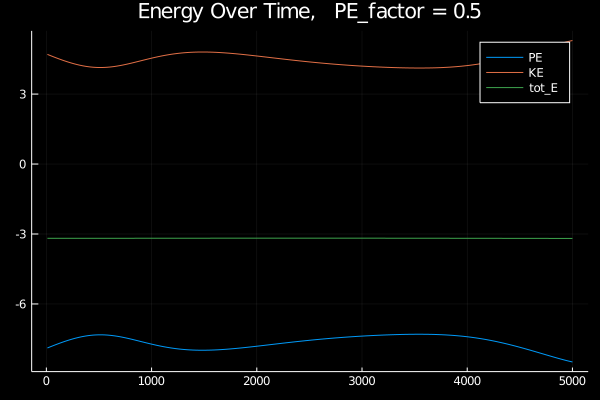

In [52]:
# TRACKING ENERGY TOTALS
"""TO DO: Total Energy should be constant over time..."""

#PE_factor has been moved to CONSTANTS at in one of the first cells

PE_list = []
KE_list = []
TE_list = []
timesteps = []

#=
for j in 1:length(samples_list)
    walk_energies(samples_list[j],PE_list,timesteps)
end
=#

# Comment this out to keep walking the current sample.
test_sample = deepcopy(samples_list[1])
#orig_sample = deepcopy(test_sample)


PE_list,KE_list,TE_list,timesteps = walk_energies(
                                    test_sample,PE_list,KE_list,TE_list,timesteps)

plot_title = "Energy Over Time,   PE_factor = "*string(PE_factor)

PEs    = plot(timesteps, PE_list, title = plot_title,
        legend = :best,label="PE",dpi = 100)
plot!(PEs,timesteps, KE_list, label="KE")
plot!(PEs,timesteps, KE_list+PE_list, label="tot_E")



In [ ]:
#===========================
            BEWARE
Running the heat capacity cells
breaks the sample-running cells...
===========================#

In [56]:
# Try out temperatures from 1 to 100 in increments of 5
maxTemp = 200
inc = 1
# From Efficient Sampling pdf by L ́ıvia B. P ́artay
α = (num_samples - 1)/num_samples
# From Nested Sampling for computational thermodynamics by L ́ıvia B. P ́artay
#α = (num_samples)/(num_samples + 1)

# Put recorded energies into units of eV/K
energies = sample_energies * ϵ_val

#"""TO DO: Figure out units!"""
Cv = zeros(convert(Int64,floor(maxTemp/inc)))
Temp = zeros(convert(Int64,floor(maxTemp/inc)))

for i in 1:length(Cv)
    Temp[i] = inc * i
    β = 1/(kB * Temp[i])
    
    
    # Calculate Zest
    Zest = 0   # Initialize value for summation
    for n in 1:length(energies)
        #Exj = deepcopy(energies[1])
        Exj = deepcopy(energies[n])
        # """Figure out meaning of E(xj)"""
        wn = α^n - α^(n+1)      # Sample weight
        Zest += wn * exp(-β*Exj)
    end
    
    # Calculate Cv
    # Initialize values for summations
    sumA = 0
    sumB = 0
    sumC = 0
    for n in 1:length(energies)
        En = deepcopy(energies[n])
        wn = α^n - α^(n+1)      # Sample weight
        
        # Units: eV / (eV/K * K^2) = 1/K
        sumA += wn * En * exp(-β*En) / (kB*Temp[i]^2) / Zest^2
        
        # Units: eV
        sumB += wn * En * exp(-β*En)
        
        # Units: eV^2 / (ev/K * K^2) = eV/K
        sumC += wn * En^2 * exp(-β*En) / (kB*Temp[i]^2)
    end
    
    # term1 would represent kinetic energy if we weren't using MD
    #term1 = 3*num_particles/2 * kB
    term2 = sumA * sumB
    term3 = 1/Zest * sumC
    
    #Cv[i] = term1 - term2 + term3
    Cv[i] = - term2 + term3
    
    print("temp: ",inc*i,"     Cv: ",Cv[i],"\n\n")
    #print("term1: ",term1,"\n")
    print("term2: ",term2,"\n")
    print("term3: ",term3,"\n")
    print("Zest: ",Zest,"\n")
    print("sumA: ",sumA,"\n")
    print("sumB: ",sumB,"\n")
    print("sumC: ",sumC,"\n\n\n")
    
end

for i in 1:length(Cv)
    print("temp: ",inc*i,"   Cv: ",Cv[i],"\n")
end

temp: 1     Cv: 7.651102862382686e-9

term2: 7.715039436828797
term3: 7.7150394444799
Zest: 4.563885633381318e126
sumA: -6.55613495055914e-125
sumB: -1.1767664172579029e125
sumC: 3.5210557681632e127


temp: 2     Cv: 7.483526510920768e-6

term2: 1.9284955764193368
term3: 1.9285030599458477
Zest: 4.8557953450781383e61
sumA: -1.5403964728982749e-60
sumB: -1.251947541006017e60
sumC: 9.364416181453992e61


temp: 3     Cv: 5.924682837921136e-5

term2: 0.8551783813499984
term3: 0.8552376281783776
Zest: 1.0886546434274569e40
sumA: -3.05021557868746e-39
sumB: -2.8036653780320362e38
sumC: 9.310584151502755e39


temp: 4     Cv: 0.00013573729871763085

term2: 0.47738247378681575
term3: 0.4775182110855334
Zest: 1.7251463338905952e29
sumA: -1.0786011190728795e-28
sumB: -4.4259408352659026e27
sumC: 8.237887912202033e28


temp: 5     Cv: 0.00018487117319732072

term2: 0.3016392885299958
term3: 0.3018241597031931
Zest: 6.165819530843462e22
sumA: -1.919096010423923e-22
sumB: -1.571777998034421e21
sumC:

term3: 0.0013283435610024965
Zest: 10.081892111519124
sumA: -0.007054138077552211
sumB: -0.16070939845734938
sumC: 0.013392216469058292


temp: 52     Cv: 0.0001906254754105751

term2: 0.0010642828325122364
term3: 0.0012549083079228115
Zest: 9.406583639577724
sumA: -0.007184670002991837
sumB: -0.14813245870291167
sumC: 0.011804399958476883


temp: 53     Cv: 0.000186507177944048

term2: 0.001000111298818738
term3: 0.001186618476762786
Zest: 8.806567175782792
sumA: -0.007298862919522981
sumB: -0.1370228910785052
sumC: 0.010450035327636527


temp: 54     Cv: 0.0001823437022555114

term2: 0.0009407091218491343
term3: 0.0011230528241046457
Zest: 8.27122890145698
sumA: -0.0073973716766323125
sumB: -0.12716802169353703
sumC: 0.009289026976597229


temp: 55     Cv: 0.0001781544617441898

term2: 0.0008856745517607494
term3: 0.0010638290135049392
Zest: 7.7917193950765835
sumA: -0.007480913823856144
sumB: -0.11839122500467673
sumC: 0.008289057157571623


temp: 56     Cv: 0.00017395697818725793



sumA: -0.005290373188891598
sumB: -0.024110911832811357
sumC: 0.0004212561921036272


temp: 101     Cv: 5.4342759832730754e-5

term2: 0.00012373438662225056
term3: 0.00017807714645498132
Zest: 2.2722674470195416
sumA: -0.0052212915764090215
sumB: -0.02369804191386487
sumC: 0.0004046389029477854


temp: 102     Cv: 5.310379417662656e-5

term2: 0.00012007351639846155
term3: 0.0001731773105750881
Zest: 2.2457973514201037
sumA: -0.005153074718769364
sumB: -0.023301334242468934
sumC: 0.0003889211454155896


temp: 103     Cv: 5.1902247059109735e-5

term2: 0.00011656466619133001
term3: 0.00016846691325043974
Zest: 2.22027093708474
sumA: -0.005085736154659944
sumB: -0.02291992007578381
sumC: 0.0003740421913503275


temp: 104     Cv: 5.0736818475205034e-5

term2: 0.0001131999158861342
term3: 0.00016393673436133923
Zest: 2.1956407249487917
sumA: -0.005019286633454561
sumB: -0.022552988931063202
sumC: 0.0003599461702788684


temp: 105     Cv: 4.9606253378015224e-5

term2: 0.0001099718328721175
te

Zest: 1.6011516639409928
sumA: -0.002911404273844066
sumB: -0.014088467801209164
sumC: 0.00010058633172763043


temp: 149     Cv: 2.1453886674933948e-5

term2: 4.026980346363773e-5
term3: 6.172369013857168e-5
Zest: 1.5937640407076437
sumA: -0.0028786775767793114
sumB: -0.013988994039649247
sumC: 9.837299780263654e-5


temp: 150     Cv: 2.111173884294846e-5

term2: 3.9542208987944966e-5
term3: 6.0653947830893426e-5
Zest: 1.5865260007829736
sumA: -0.0028464631948635927
sumB: -0.013891698673391732
sumC: 9.622906528384646e-5


temp: 151     Cv: 2.0777340669816116e-5

term2: 3.883376097183416e-5
term3: 5.961110164165028e-5
Zest: 1.579433135420862
sumA: -0.002814751741046371
sumB: -0.013796513705112015
sumC: 9.415174917176339e-5


temp: 152     Cv: 2.0450470268012874e-5

term2: 3.8143806858683766e-5
term3: 5.859427712669664e-5
Zest: 1.572481204490896
sumA: -0.002783533986897991
sumB: -0.013703373854325289
sumC: 9.213839947246129e-5


temp: 153     Cv: 2.013091326168081e-5

term2: 3.747172112

sumC: 4.122705116795986e-5


temp: 198     Cv: 1.088917847920414e-5

term2: 1.90715886589391e-5
term3: 2.996076713814324e-5
Zest: 1.3556602985821633
sumA: -0.0017526327786367376
sumB: -0.010881679774227253
sumC: 4.061662252424593e-5


temp: 199     Cv: 1.0760474478630067e-5

term2: 1.8829507855410353e-5
term3: 2.958998233404042e-5
Zest: 1.3524614117200153
sumA: -0.00173682110392043
sumB: -0.010841362885853672
sumC: 4.0019309280266624e-5


temp: 200     Cv: 1.0633979656248625e-5

term2: 1.859196363349797e-5
term3: 2.9225943289746595e-5
Zest: 1.3493061826923374
sumA: -0.001721217237312614
sumB: -0.010801636905824938
sumC: 3.943474597587071e-5


temp: 1   Cv: 7.651102862382686e-9
temp: 2   Cv: 7.483526510920768e-6
temp: 3   Cv: 5.924682837921136e-5
temp: 4   Cv: 0.00013573729871763085
temp: 5   Cv: 0.00018487117319732072
temp: 6   Cv: 0.00019811275713549348
temp: 7   Cv: 0.00019307889260583577
temp: 8   Cv: 0.00018446923562601136
temp: 9   Cv: 0.00017844946737501088
temp: 10   Cv: 0.00017

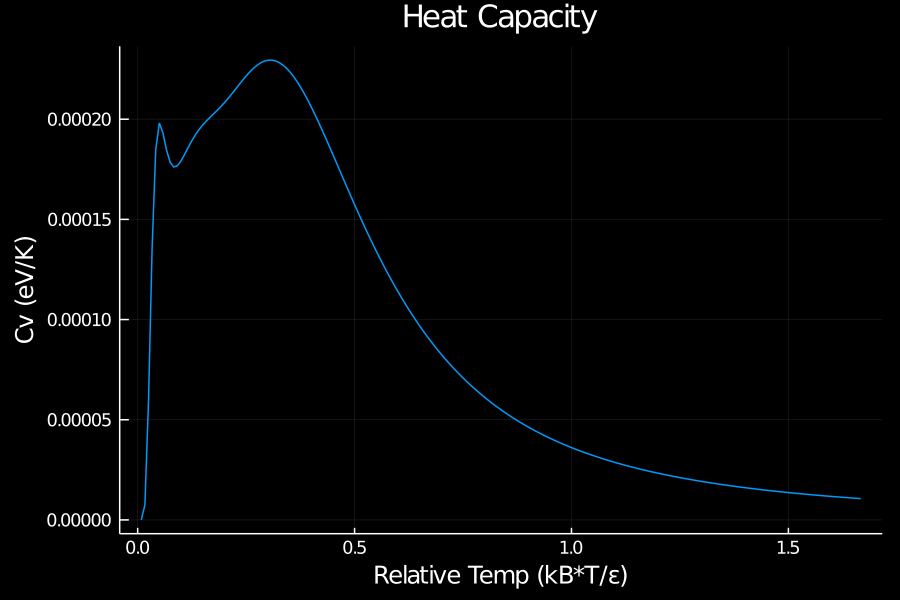

In [57]:
plot(kB*Temp/ϵ_val, Cv, title = "Heat Capacity", ylabel = "Cv (eV/K)", xlabel = "Relative Temp (kB*T/ε)",
            dpi = 150)

sample energy 1: -0.002271745353911106
sample energy 2: -0.0024119461196975456
sample energy 3: -0.0024166034618494903
sample energy 4: -0.0028663503576792215
sample energy 5: -0.002876971413730129
sample energy 6: -0.003352071228362046
sample energy 7: -0.0046848759210634415
sample energy 8: -0.004900419442801666
sample energy 9: -0.005944881154710538
sample energy 10: -0.006318279824318456
sample energy 11: -0.006308193218601067
sample energy 12: -0.007882951904009353
sample energy 13: -0.008294023588926053
sample energy 14: -0.008573881362039204
sample energy 15: -0.008884308871147925
sample energy 16: -0.009157608580444055
sample energy 17: -0.009732608409181732
sample energy 18: -0.010375698253604676
sample energy 19: -0.01239999383916752
sample energy 20: -0.012701692913321258
sample energy 21: -0.013393626106452804
sample energy 22: -0.013984356968082834
sample energy 23: -0.01484138661082168
sample energy 24: -0.015028128146064836
sample energy 25: -0.016376353115819118
sample 

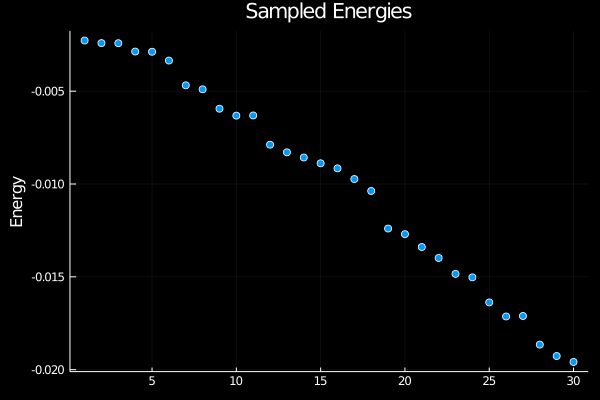

In [27]:
# Looking at recorded sample energies

# Put recorded energies into units of eV/K
energies = sample_energies * ϵ_val

index = zeros(length(energies))
for i in 1:length(energies)
    print("sample energy "*string(i)*": ",energies[i],"\n")
    index[i]=i
end

scatter(index, energies, title = "Sampled Energies", ylabel = "Energy",
            dpi = 100)

In [29]:
#=
TO DO LIST (heat capacity):
- Relate energy or velocities to temperature
- Record high energies eliminated
- Cv = -(δ/δT δlnZ/δβ)v
    - β = 1/(kT)
    - k = kB = Bolzmann constant
    - En = energy recorded at level n
    UNITLESS
    - K = num_samples
    - wn = α^n - α^(n+1)
    - α = (K-1)/K
    - N = number of particles in a sample
    - Zest  = Σn [α^n - α^(n+1)] * [exp(-β*E(xj))]
        (this only works for our specific choice of α)
- GOAL: T in kelvins, Cv in eV per kelvin
* E_tot can exceed its original value... value should be constant
=#


# HEAT CAPACITY array as function of temperature array
# Make an array of temperatures

# For each T:
# Use a loop to iterate n for every En in sample_energies
# α = (K-1)/K
# β = 1/(kB*T)
# Zest  = Σn [α^n - α^(n+1)] * [exp(-β*E(xj))]
# E(xj) represents a sample between energy levels En and En+1
        # I think that E(xj) is either just En or maybe E0
"""Figure out meaning of E(xj)"""
# Cv(T) = 3*N/2*kB - sum((α^n - α^(n+1))*En*exp(-β*En)/(kB*T^2))/Zest^2 * \
#                    sum(wn*En*exp(-β*En)) + 1/Zest*sum((α^n - α^(n+1))*En^2*exp(-β*En)/(kB*T^2))

"Figure out meaning of E(xj)"

In [ ]:
?convert

In [ ]:
#=
# Heat Capacity Calculation
#= from pg.1-9 of "Efficient sampling of aatomic configuration spaces"
 by Lívia B. Pártay, Albert P. Bartók, and Gábor Csányi =#

Cv = 3*N/2*kB - Σ_n(ω_n*E_n*exp(-β*E_n)/(kB*T^2))/Zest^2 * Σ_n(ω_n*E_n*exp(-β*E_n))
 + 1/Zest * Σ_n(ω_n * E_n^2 * exp(-β*E_n)/(kB*T^2))

N = number of particles
kB = Boltzmann constant
ω_n = α^n - α^(n+1)
α = (K-1)/K
K = number of samples
Zest = Σ_n(ω_n)*Σ_j(exp(-β*E(xj)))
E_n < E(xj) < E_n+1
E = potential energy #lennard jones potential!
T = temperature in K


=#

In [ ]:
"""TO DO: Figure out how to plot all samples at once"""

#=

println("This cell is almost done...")

function p(k,i)
    lim = L
    dotsize = 3

    scatter(x_for_anim[k][i], y_for_anim[k][i], markersize = dotsize, 
            xlims = (-lim,lim), ylims = (-lim,lim),
            ylabel = plotnames[k], size = (800,800), aspectratio = 1)
    
end



subplots_anim = @animate for i = 1:length(x_for_anim[1])

    plot(p(1,i), p(2,i), p(3,i), p(4,i), p(5,i), p(6,i))
    
end

# DO NOT RUN THIS UNTIL YOU KNOW WHERE IT WILL SAVE TO
# gif(subplots_anim,"all_methods.gif")

=#

println("This cell is almost done...")

function mp4_p(k,i,plotname)
    lim = L
    dotsize = 3

    scatter(x_for_anim[k][i], y_for_anim[k][i], title = plotname,
            markersize = dotsize, xlims = (-lim,lim), ylims = (-lim,lim), 
            dpi = 150, aspectratio = 1)
    
end


# This will hopefully work for the first three samples of an group
samples_anim = @animate for i = 1:length(x_for_anim[1])

    # TO DO: make a loop that will do this for any number of samples    
    plot(mp4_p(1,i,plotnames[1]),mp4_p(2,i,plotnames[2]),mp4_p(3,i,plotnames[3]),mp4_p(4,i,plotnames[4]))

end

# mp4(LJ_anim,"./tmp_animations/LennardJones.mp4");
mp4(samples_anim,"./tmp_animations/all_samples.mp4");



In [19]:
# Creating mp4 files of each sample

"""TO DO: Create large mp4 showing all samples walking simultaneously"""

println("This cell is almost done...")

function mp4_p(k,i,plotnames)
    lim = L
    dotsize = 3

    scatter(x_for_anim[k][i], y_for_anim[k][i], title = plotnames[k],
            markersize = dotsize, xlims = (-lim,lim), ylims = (-lim,lim), 
            dpi = 150, aspectratio = 1)
    
end

"""TO DO: figure out why @animate is causing an error"""
for k in 1:length(animfile_names)   
    LJ_anim = @animate for i = 1:length(x_for_anim[k])

        plot(mp4_p(k,i,plotnames))

    end


    # mp4(LJ_anim,"./tmp_animations/LennardJones.mp4");
    mp4(LJ_anim,"./tmp_animations/"*animfile_names[k]*".mp4");
end

This cell is almost done...


LoadError: LoadError: UndefVarError: @animate not defined
in expression starting at In[19]:19

In [20]:
println("This cell is almost done...")

function p(k,i)
    lim = L
    dotsize = 3

    scatter(x_for_anim[k][i], y_for_anim[k][i], title = plotnames[k],
            markersize = dotsize, 
            xlims = (-lim,lim), ylims = (-lim,lim), 
            size = (350,350), dpi=150, aspectratio = 1)
    
end


for k in 1:length(animfile_names)
    plot_anim = @animate for i = 1:length(x_for_anim[k])

        plot(p(k,i))

    end

    # gif(plot_anim,"./tmp_animations/MD.gif")
    gif(plot_anim,"./tmp_animations/"*animfile_names[k]*".gif")
end

This cell is almost done...


LoadError: LoadError: UndefVarError: @animate not defined
in expression starting at In[20]:16